# WITBook

This notebook demonstrates the method for reproducing results from the Wetlands Insight Tool.

## Setup

Import packages:

In [98]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
from dea_tools.spatial import xr_rasterize
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

Connect to the datacube:

In [99]:
dc = datacube.Datacube(app='witbook')

## Data loading

Load a shapefile with the polygon of interest:

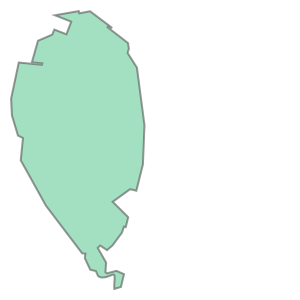

In [100]:
poly = gpd.read_file('hird/hird.shp')
poly.geometry[0]

...and specify a time period to examine:

In [ ]:
time = ('1995-01-01', '2000-01-01')

Then load Landsat, Water Observations, and Fractional Cover:

In [ ]:
bands = [f'nbart_{band}' for band in ('blue', 'green', 'red', 'nir', 'swir_1', 'swir_2')]

In [ ]:
gpgon = datacube.utils.geometry.Geometry(poly.geometry[0], crs=poly.crs)

In [ ]:
ds = dea_tools.datahandling.load_ard(dc, products=['ga_ls8c_ard_3', 'ga_ls7e_ard_3', 'ga_ls5t_ard_3'], ls7_slc_off=False, measurements=bands,
                                     geopolygon=gpgon,
                                     output_crs='EPSG:3577', resolution=(-30, 30), resampling={'fmask': 'nearest', '*': 'bilinear'},
                                     time=time, group_by='solar_day')

In [ ]:
ds_wo = dc.load('ga_ls_wo_3', resampling='nearest', group_by='solar_day', like=ds)
ds_fc = dc.load('ga_ls_fc_3', resampling='nearest', group_by='solar_day', like=ds)

Find any missing observations:

In [ ]:
missing = set()
for t1, t2 in itertools.product(
        [ds_fc.time.values, ds_wo.time.values, ds.time.values], repeat=2):
    missing_ = set(t1) - set(t2)
    missing |= missing_

...and delete them:

In [ ]:
ds_fc = ds_fc.sel(time=[t for t in ds_fc.time.values if t not in missing])
ds = ds.sel(time=[t for t in ds.time.values if t not in missing])
ds_wo = ds_wo.sel(time=[t for t in ds_wo.time.values if t not in missing])

Finally, calculate Tasseled-Cap Wetness:

In [ ]:
tcw = dea_tools.bandindices.calculate_indices(
    ds, index='TCW', collection='ga_ls_3',
    normalise=False, drop=True, inplace=False)

## WIT calculation

For each pixel, we calculate its WIT values based on the Flowchart from Dunn et al. (in prep).

Find all the WO-identified open water pixels:

In [ ]:
open_water = ds_wo.water & (1 << 7) > 0

Find all the TCW-identified "wet" pixels:

In [ ]:
wet = tcw.where(~mask).TCW > -350

Divide out the FC values by 100 to keep them in $[0, 1]$ (ignoring for now that values can exceed 100 due to how FC is calculated):

In [ ]:
bs = ds_fc.bs / 100
pv = ds_fc.pv / 100
npv = ds_fc.npv / 100

Generate the WIT raster bands:

In [ ]:
rast_names = ['pv', 'npv', 'bs', 'wet', 'water']
output_rast = {n: xr.zeros_like(bs) for n in rast_names}

In [ ]:
output_rast['bs'].values[:] = bs
output_rast['pv'].values[:] = pv
output_rast['npv'].values[:] = npv

In [ ]:
# TCW
output_rast['wet'].values[:] = wet.values.astype(float)
for name in rast_names[:3]:
    output_rast[name].values[wet.values] = 0

In [ ]:
# WO
output_rast['water'].values[:] = open_water.values.astype(float)
for name in rast_names[:4]:
    output_rast[name].values[open_water.values] = 0

Mask cloudy/cloud shadowy/noncontiguous/no-data pixels and pixels not in the polygon:

In [ ]:
poly_raster = xr_rasterize(poly, bs) > 0

In [ ]:
mask = (ds_wo.water & 0b0110011) == 0
mask &= poly_raster

In [ ]:
ds_wit = xr.Dataset(output_rast).where(mask)

Mask entire observations where the polygon is more than 10% masked:

In [122]:
pc_missing = (~mask).where(poly_raster).mean(dim=['x', 'y'])

In [123]:
ds_wit = ds_wit.where(pc_missing < 0.1)

The WIT results are now computed. All that's left is to display them.

## Aspatial display

In [151]:
def display_wit_stack(ds_wit):
    pal = ['#030aa7',
           '#04d9ff',
           '#3f9b0b',
           '#e6daa6',
           '#60460f']
    bands = ['water', 'wet', 'pv', 'npv', 'bs']
    xs = ds_wit.time.values
    ys = ds_wit[bands].to_array().mean(dim=['x', 'y'])
    # clip to 0, 1
    ys = ys.clip(0, 1)
    # renormalise
    ys = ys / ys.sum(dim='variable')
    all_null = ds_wit.bs.isnull().all(dim=['x', 'y'])
    xs = gpd.pd.to_datetime(xs[~all_null])
    ys = ys.values[:, ~all_null]
    plt.stackplot(xs, ys,
                  colors=pal, alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel('Fraction')
    plt.xlim(xs.min(), xs.max())
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

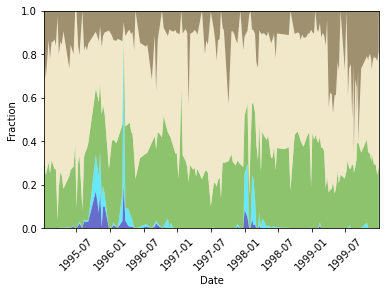

In [152]:
display_wit_stack(ds_wit)